In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
from torch import nn
import torch
from scipy import ndimage
import time


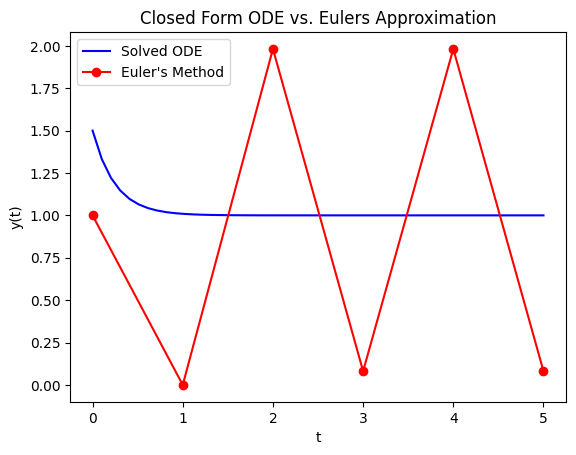

In [81]:
#plotting the Eulers method vs Solved ODE
x_points_euler= [0,1,2,3,4,5]
y_points_euler = [1,0,1.9817, 0.0813, 1.9817, 0.0813]

def f(t):
    return 1 + (np.exp(-4 * t) / 2)

t = np.linspace(0,5)

plt.plot(t, f(t), color="blue", label="Solved ODE")
plt.plot(x_points_euler, y_points_euler, color="red", label="Euler's Method", marker='o')
plt.xlabel("t")
plt.ylabel("y(t)")
plt.title("Closed Form ODE vs. Eulers Approximation")
plt.legend()
plt.show()


Plotting w/ Different Step Size 

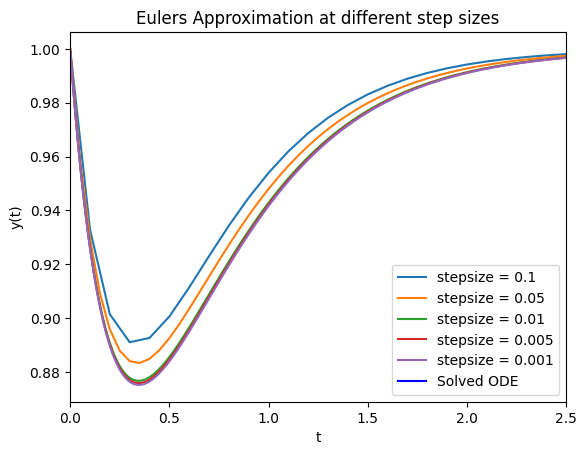

In [82]:
def ode(y ,t):
    return (-2*y) + 2 - np.exp(-4*t)
 
def eulers_formula(y_prev,stepsize,t):
    return y_prev + stepsize* ode(y_prev, t)


def eulers_approximation(h = [0.1,0.05, 0.01, 0.005, 0.001]):
    y_init = 1

    for step_size in h:
        y = y_init
        eulers_y_values = []
        t_values = np.arange(0, 5+step_size,step_size)
        eulers_y_values.append(y)


        for t in t_values[1:]:
            y = eulers_formula(y,step_size, t)
            eulers_y_values.append(y)

        plt.plot(t_values, eulers_y_values, label =f"stepsize = {step_size}")



    plt.plot(t, f(t), color="blue", label="Solved ODE")
    plt.title("Eulers Approximation at different step sizes")
    plt.xlabel("t")
    plt.ylabel("y(t)")
    plt.xlim(0,2.5)
    plt.legend()
    plt.show()
        
eulers_approximation()
            

2a)


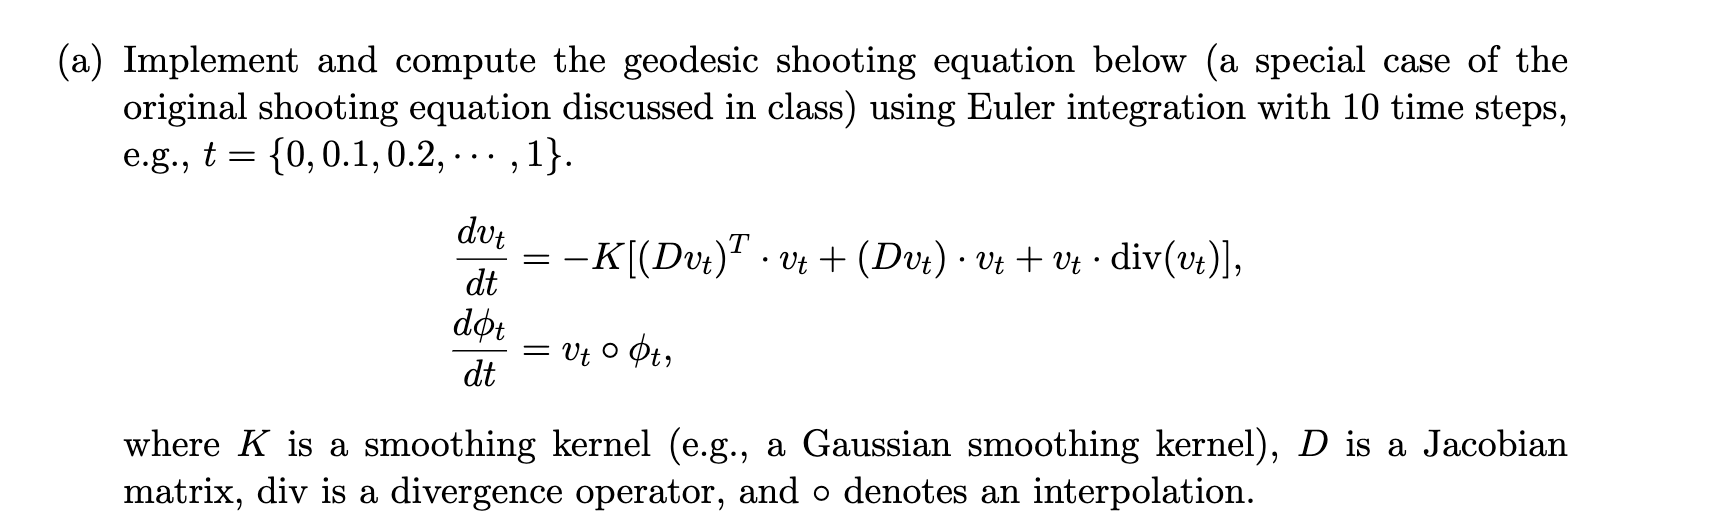

In [2]:
#finddin the jacobian of v partials in each direction
def compute_jacobian(v):
    vx, vy = v[0], v[1]
    dvxx, dvxy = np.gradient(vx)
    dvyx, dvyy = np.gradient(vy)
    return np.array([[dvxx, dvxy], [dvyx, dvyy]])

# computing divergence similar top ps1 except not using divergences
def compute_divergence(v):
    vx, vy = v[0], v[1]
    dvxx = np.gradient(vx, axis=0)
    dvyy = np.gradient(vy, axis=1)
    return np.sqrt(dvxx**2 + dvyy**2)

'''I used  assistence chatgpt in this method for matrix products as I was 
having difficulties with matrix multiplication dimensionalitie mismatches and broadcasting issues credits to OpenAI'''
def eulers_integration(v, phi, h, var):
    jacobian = compute_jacobian(v)  # (2, 2, 100, 100)
    div_v = compute_divergence(v)   # (100, 100)

    v = np.stack((v[0], v[1]), axis=-1) #(100, 100, 2)
    
    # Transposing Jacobian
    jacobian = np.moveaxis(jacobian, [0, 1], [-2, -1])  # (100, 100, 2, 2)

    term1 = np.einsum('...ij,...j->...i', jacobian, v)  #(100, 100, 2)
    
    # Element-wise product with divergence
    term2 = term1  # (redundant in this case, can be customized)
    term3 = v * div_v[..., np.newaxis]  # (100, 100, 2)

    # Update velocity using the given equation
    sigma = np.sqrt(var)
    dvdt = -ndimage.gaussian_filter(term1 + term2 + term3, sigma=sigma)
    v_new = v + h * dvdt

    # Update deformation field φ using v
    phi = np.stack((phi[0], phi[1]), axis=-1)  # (100, 100, 2)
    dphidt = v  
    phi_new = phi + h * dphidt

    return v_new, phi_new


In [45]:
def compute_jacobian(v):
    vx, vy = v[0], v[1]
    dvxx, dvxy = np.gradient(vx)
    dvyx, dvyy = np.gradient(vy)
    return dvxx,dvxy,dvyx, dvyy

def compute_divergence(v):
    vx, vy = v[0], v[1]
    dvxx = np.gradient(vx, axis=0)
    dvyy = np.gradient(vy, axis=1)
    return dvxx+dvyy

def eulers_integration(v, phi_x,phi_y, h, var):

    vx, vy = v[0], v[1]
    #getting the partials for jacobian matrix
    dvxx,dvxy,dvyx, dvyy= compute_jacobian(v)  
    div_v = compute_divergence(v)   # (100, 100)
    

    inner_term_x = (dvxx*vx) + (dvyx*vy)+ (dvxx *vx) + (dvxy* vy) + (div_v *vx)
    inner_term_y = (dvxy*vx) + (dvyy*vy)+ (dvyx *vx) + (dvyy* vy) + (div_v *vy)

    sigma = np.sqrt(var)
    dvxdt = -ndimage.gaussian_filter(inner_term_x, sigma = sigma)
    dvydt = -ndimage.gaussian_filter(inner_term_y, sigma = sigma)


    vx_new = vx - h * dvxdt
    vy_new = vy - h * dvydt

    dphixdt = vx_new
    dphiydt = vy_new

    phi_x_new = phi_x + h * dphixdt
    phi_y_new = phi_y + h * dphiydt

    return vx_new, vy_new, phi_x_new, phi_y_new

2b)

In [51]:
# loading data
v0 = torch.load("PS2_Q2/code+data/v0.pt").numpy()  
source_image = torch.load("PS2_Q2/code+data/source.pt").numpy()  

vx, vy = v0[0], v0[1]
# params
dt = 0.1
timesteps = np.arange(0,1,dt)  

# phi 0 meshgrid
x = np.linspace(0,99,100)
y = np.linspace(0,99,100)
phi_x, phi_y = np.meshgrid(x, y)  #deformation field

# print(phi.shape)
start_time =  0
end_time = 0 

start_time = time.time()
images = [source_image]
start_time = time.time()

for t in timesteps:

    vx, vy, phi_x, phi_y = eulers_integration(v0, phi_x, phi_y, dt, 1)
    v0 = np.stack([vx,vy])
    images.append(ndimage.map_coordinates(source_image,[phi_y, phi_x],order = 3 ))

end_time = time.time()




Deformed Image

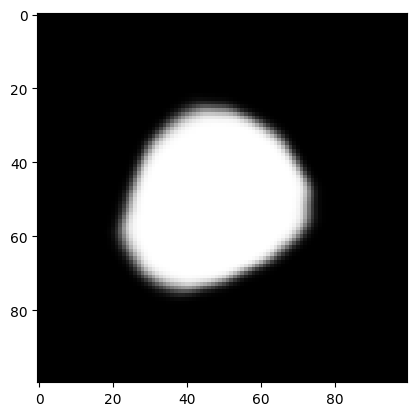

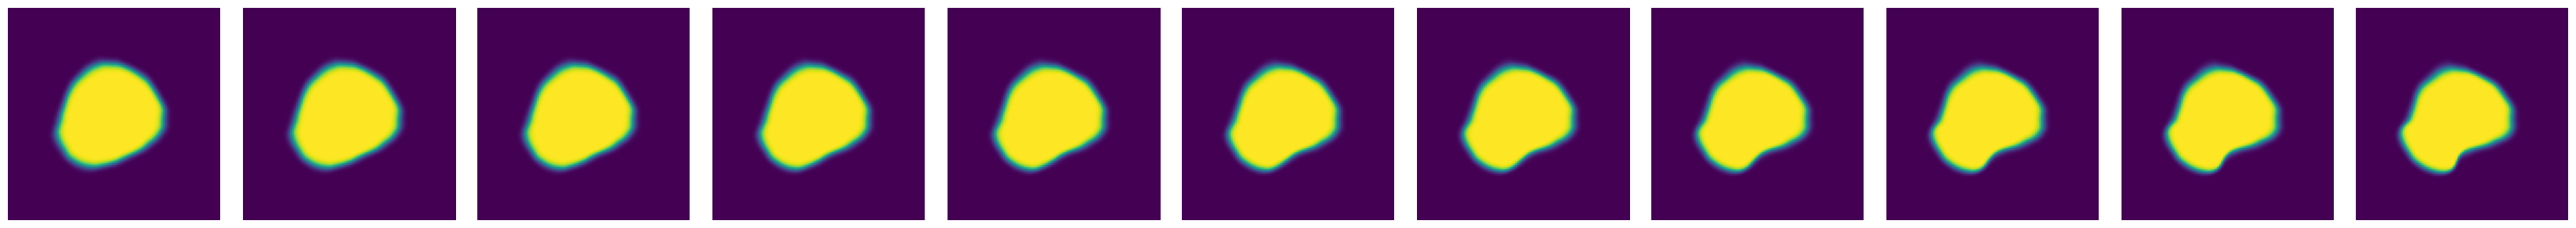

In [55]:
n_images = len(images)

# Create subplots with one row and as many columns as there are images
fig, axes = plt.subplots(1, n_images, figsize=(n_images * 3, 3))  # adjust figsize for better display

if n_images == 1:
    axes = [axes]

for i, image in enumerate(images):
    axes[i].imshow(image, cmap = )
    axes[i].axis('off')  # Turn off the axis for a cleaner look

plt.tight_layout()
plt.show()



2c

In [102]:
elapsed_time = end_time-start_time
print(f"Program took {elapsed_time} seconds to complete")

Program took 0.00019097328186035156 seconds to complete


2d)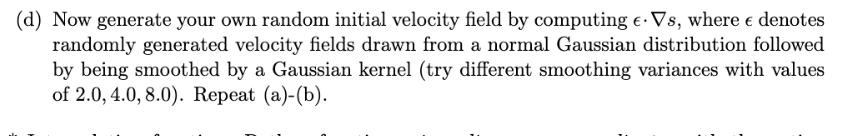

In [115]:
#finddin the jacobian of v partials in each direction
def compute_jacobian(v):
    vx, vy = v[0], v[1]
    dvxx, dvxy = np.gradient(vx)
    dvyx, dvyy = np.gradient(vy)
    return np.array([[dvxx, dvxy], [dvyx, dvyy]])

# computing divergence similar top ps1 except not using divergences
def compute_divergence(v):
    vx, vy = v[0], v[1]
    dvxx = np.gradient(vx, axis=0)
    dvyy = np.gradient(vy, axis=1)
    return np.sqrt(dvxx**2 + dvyy**2)
'''I used  assistence chatgpt in this method for matrix products as I was 
having difficulties with matrix multiplication dimensionalitie mismatches and broadcasting issues credits to OpenAI'''
def eulers_integration(v, phi, h, var):
    jacobian = compute_jacobian(v)  # (2, 2, 100, 100)
    div_v = compute_divergence(v)   # (100, 100)

    v = np.stack((v[0], v[1]), axis=-1) #(100, 100, 2)
    
    # Transposing Jacobian
    jacobian = np.moveaxis(jacobian, [0, 1], [-2, -1])  # (100, 100, 2, 2)
    

    term1 = np.einsum('...ij,...j->...i', jacobian, v)  #(100, 100, 2)
    
    # Element-wise product with divergence
    term2 = term1  # (redundant in this case, can be customized)

    term3 = v * div_v[..., np.newaxis]  # (100, 100, 2)

    # Update velocity using the given equation
    sigma = np.sqrt(var)
    dvdt = -ndimage.gaussian_filter(term1 + term2 + term3, sigma=sigma)
    v_new = v + h * dvdt

    # Update deformation field φ using v
    phi = np.stack((phi[0], phi[1]), axis=-1)  # (100, 100, 2)
    dphidt = v  
    phi_new = phi + h * dphidt

    return v_new, phi_new




In [140]:
# loading data
v0 = torch.load("PS2_Q2/code+data/v0.pt").numpy()  
source_image = torch.load("PS2_Q2/code+data/source.pt").numpy()  


# params
dt = 0.1
timesteps = np.arange(0,1,dt)  

# phi 0 meshgrid
x = np.linspace(0,99, 100)
y = np.linspace(0, 99,100)
phi = np.meshgrid(x, y)  #deformation field

epsilon = np.random.randn(2,100,100)
epsilon_x = epsilon[0] 
epsilon_y = epsilon[1]




div_sx = np.gradient(source_image, axis = 0)
div_sy = np.gradient(source_image, axis = 1)
gradient_term = np.sqrt(div_sx**2 + div_sy**2)

v0_x = epsilon_x *gradient_term
v0_y = epsilon_y * gradient_term
v0 = np.stack([v0_x,v0_y], axis = 0)


variances =[2.0,4.0,8.0]
gaussian_blurred_vs ={}
for var in variances:
    sigma = np.sqrt(var)
    gaussian_blurred_vs[var]= ndimage.gaussian_filter(v0, sigma = sigma)



for t in timesteps:
    gaussian_blurred_vs[2.0], phi = eulers_integration(gaussian_blurred_vs[2.0], phi, dt, 2)


x = np.linspace(0,99, 100)
y = np.linspace(0, 99,100)
phi = np.meshgrid(x, y)  #deformation field
for t in timesteps:
    gaussian_blurred_vs[4.0], phi = eulers_integration(gaussian_blurred_vs[4.0], phi, dt, 4)

x = np.linspace(0,99, 100)
y = np.linspace(0, 99,100)
phi = np.meshgrid(x, y)  #deformation field
for t in timesteps:
    gaussian_blurred_vs[8.0], phi = eulers_integration(gaussian_blurred_vs[8.0], phi, dt, 8)


print(f"Final Velocity is :{gaussian_blurred_vs[2.0]} ")
print(f"Final Velocity is :{gaussian_blurred_vs[4.0]} ")
print(f"Final Velocity is :{gaussian_blurred_vs[8.0]} ")


Final Velocity is :[[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]] 
Final Velocity is :[[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]] 
Final Velocity is :[[[-1.58423658e-70 -1.58423658e-70]
  [-1.45464477e-68 -1.45464477e-68]]

 [[-1.58428271e-70 -1.58428271e-70]
  [ 3.18583890e-54  3.18583890e-54]]] 
